In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
from dotenv import load_dotenv 
import sqlalchemy as sa
import os
from requests import HTTPError
import numpy as np
import matplotlib.pyplot as plt

In [2]:
load_dotenv('mysql.env')
url_banco = "localhost"
nome_db = "movie_db"
conn_str = f"mysql+pymysql://{os.getenv('MYSQL_USER')}:{os.getenv('MYSQL_PASS')}@{url_banco}/{nome_db}"
engine = sa.create_engine(conn_str)

In [3]:

df = pd.read_csv("movies_metadata.csv", dtype = "str", parse_dates = ["release_date"], infer_datetime_format = True)
df.head()
df = df[df["imdb_id"] != "0"]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   adult                  45463 non-null  object
 1   belongs_to_collection  4491 non-null   object
 2   budget                 45463 non-null  object
 3   genres                 45463 non-null  object
 4   homepage               7779 non-null   object
 5   id                     45463 non-null  object
 6   imdb_id                45446 non-null  object
 7   original_language      45452 non-null  object
 8   original_title         45463 non-null  object
 9   overview               44509 non-null  object
 10  popularity             45460 non-null  object
 11  poster_path            45077 non-null  object
 12  production_companies   45460 non-null  object
 13  production_countries   45460 non-null  object
 14  release_date           45376 non-null  object
 15  revenue            

In [4]:
df.drop(['adult', 'belongs_to_collection', 'homepage', 'original_language', 'overview', 'runtime', 'spoken_languages', 'status', 'tagline', 'video'], axis=1, inplace=True)


In [5]:
df.head()

,budget,genres,id,imdb_id,original_title,popularity,poster_path,production_companies,production_countries,release_date,revenue,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,Toy Story,21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,Toy Story,7.7,5415
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,Jumanji,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249,Jumanji,6.9,2413
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,Grumpier Old Men,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0,Grumpier Old Men,6.5,92
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,Waiting to Exhale,3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156,Waiting to Exhale,6.1,34
4,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,Father of the Bride Part II,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911,Father of the Bride Part II,5.7,173


In [6]:
mask_teste = df["release_date"] > "2020-01-01"
df_teste = df[mask_teste]
df_teste

,budget,genres,id,imdb_id,original_title,popularity,poster_path,production_companies,production_countries,release_date,revenue,title,vote_average,vote_count
26559,0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",76600,tt1630029,Avatar 2,6.020055,/wvpOVl37PR21mENpmZKVwrLUsRD.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2020-12-16,0,Avatar 2,0.0,58


In [7]:
def limpeza_lista(string_lista):
    '''
    Função para limpar as colunas da Base gerada pela Neoway que contem listas
    '''
    if pd.isnull(string_lista):
        resultado = np.nan
    else:
        resultado = eval(string_lista)
    return resultado

df_genres = df[['imdb_id' ,'genres']].copy()
df_genres['genres'] = df_genres['genres'].map(limpeza_lista)
df_genres.info()


df_genres = df_genres.explode('genres')
df_genres

df_genres['genres'] = df_genres['genres'].map(lambda x: x['name'] if type(x) == dict else np.nan)
df_genres.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   imdb_id  45446 non-null  object
 1   genres   45463 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


,imdb_id,genres
0,tt0114709,Animation
0,tt0114709,Comedy
0,tt0114709,Family
1,tt0113497,Adventure
1,tt0113497,Fantasy


In [8]:
df_pc = df[['imdb_id' ,'production_companies']].copy()
df_pc['production_companies'] = df_pc['production_companies'].map(limpeza_lista)
df_pc.info()


df_pc = df_pc.explode('production_companies')
df_pc

df_pc['production_companies'] = df_pc['production_companies'].map(lambda x: x['name'] if type(x) == dict else np.nan)
df_pc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   imdb_id               45446 non-null  object
 1   production_companies  45460 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


,imdb_id,production_companies
0,tt0114709,Pixar Animation Studios
1,tt0113497,TriStar Pictures
1,tt0113497,Teitler Film
1,tt0113497,Interscope Communications
2,tt0113228,Warner Bros.


In [9]:
df_countries = df[['imdb_id' ,'production_countries']].copy()
df_countries['production_countries'] = df_countries['production_countries'].map(limpeza_lista)
df_countries.info()


df_countries = df_countries.explode('production_countries')
df_countries

df_countries['production_countries'] = df_countries['production_countries'].map(lambda x: x['name'] if type(x) == dict else np.nan)
df_countries.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   imdb_id               45446 non-null  object
 1   production_countries  45460 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


,imdb_id,production_countries
0,tt0114709,United States of America
1,tt0113497,United States of America
2,tt0113228,United States of America
3,tt0114885,United States of America
4,tt0113041,United States of America


In [10]:
df_release = df[['imdb_id' ,'release_date']].copy()
df_release.head()
df_release["release_date"] = pd.to_datetime(df_release["release_date"])
#df['Date'] = df['Date'].astype('datetime64[ns]')
#df_release.loc[10395, "release_date"]
#pd.to_datetime(df_release["release_date"])
#[date for date in list(df_release["release_date"].unique()) if len(str(date)) < 10]

#type(df_release.loc[0, "release_date"])

In [11]:
df_countries.to_sql('countries', engine, index = False, if_exists = 'replace')
df_pc.to_sql('companies', engine, index = False, if_exists = 'replace')
df_genres.to_sql('genres', engine, index = False, if_exists = 'replace')
df_release.to_sql('release', engine, index = False, if_exists = 'replace')

45463

In [12]:
#query = "SELECT * from movies join release on release.imdb_id = movies.imdb_id join genres on genres.imdb_id = release.imdb_id join countries on countries.imdb_id = genres.imdb_id join companies on companies.imdb_id = countries.imdb_id"

In [13]:
query = '''SELECT *
FROM movies
JOIN `release` ON release.imdb_id = movies.imdb_id
JOIN genres ON genres.imdb_id = movies.imdb_id
JOIN countries ON countries.imdb_id = movies.imdb_id
JOIN companies ON companies.imdb_id = countries.imdb_id'''

In [43]:
df_joined = pd.read_sql(query, engine)


In [44]:
df_joined.columns = ['Title', 'rating_imdb', 'rating_mc', 'imdb_id_ok', 'imdb_votes', 'Revenue',
       'imdb_id', 'release_date', 'imdb_id', 'genres', 'imdb_id',
       'production_countries', 'imdb_id', 'production_companies']


In [45]:
 
df_joined.drop('imdb_id', axis = 1, inplace = True)

In [46]:
df_joined.columns = ['Title', 'rating_imdb', 'rating_mc', 'imdb_id', 'imdb_votes',
       'Revenue', 'release_date', 'genres', 'production_countries',
       'production_companies']

In [47]:
#df_joined.info()

df_joined["Revenue"] = df_joined.Revenue.str.replace("$", "").str.replace(",", "")

df_joined["rating_imdb"] = pd.to_numeric(df_joined["rating_imdb"], errors = "coerce")
df_joined["Revenue"] = pd.to_numeric(df_joined["Revenue"], errors = "coerce")

C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_2732\3321857265.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_joined["Revenue"] = df_joined.Revenue.str.replace("$", "").str.replace(",", "")


In [48]:
mask_normal = df_joined['release_date'].dt.year > 2010
df_full = df_joined[mask_normal]


In [51]:
df_full

,Title,rating_imdb,rating_mc,imdb_id,imdb_votes,Revenue,release_date,genres,production_countries,production_companies
2,The Sleepover,6.8,N/A,tt2250194,119,NaN,2013-10-12,Comedy,None,None
3,The Sleepover,6.8,N/A,tt2250194,119,NaN,2013-10-12,Horror,None,None
4,The Farmer's Wife,7.5,N/A,tt2140519,19,NaN,2012-06-20,Drama,None,None
5,A Place at the Table,6.9,68,tt1736049,"1,203",231378.0,2012-03-22,Documentary,United States of America,None
6,A Place at the Table,6.9,68,tt1736049,"1,203",231378.0,2012-03-22,Documentary,United States of America,None
...,...,...,...,...,...,...,...,...,...,...
87281,Collaborator,6.0,56,tt1555058,870,NaN,2011-10-08,Drama,Canada,This Is That Productions
87282,Collaborator,6.0,56,tt1555058,870,NaN,2011-10-08,Drama,United States of America,This Is That Productions
87283,The Foxy Merkins,6.1,42,tt2971990,142,NaN,2013-08-09,Comedy,United States of America,Wisconsin
87284,The Foxy Merkins,6.1,42,tt2971990,142,NaN,2013-08-09,Adventure,United States of America,Wisconsin


Text(0.5, 1.0, 'Top Genres')

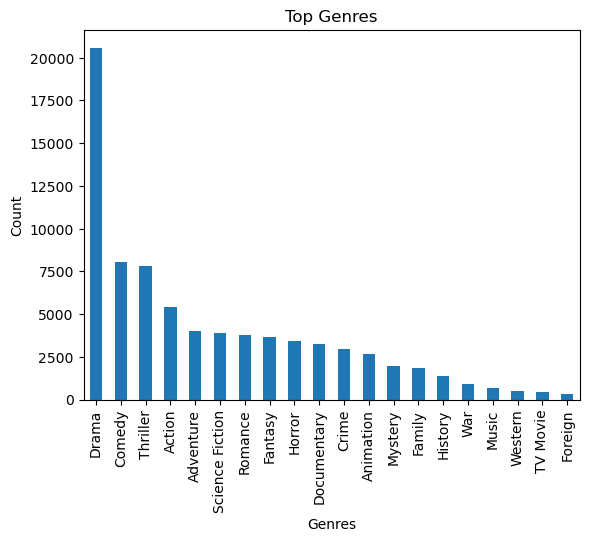

In [84]:
df_full.genres.value_counts().plot(kind = "bar")
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Top Genres")

Text(0.5, 1.0, 'Revenue por genre')

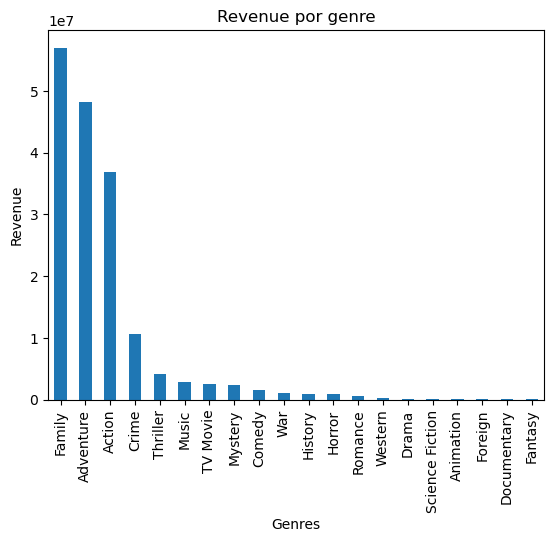

In [85]:
df_full.groupby(by = "genres").Revenue.median().sort_values(ascending=False).plot(kind = "bar")
plt.xlabel("Genres")
plt.ylabel("Revenue")
plt.title("Revenue por genre")

Text(0.5, 1.0, 'Score per Genre')

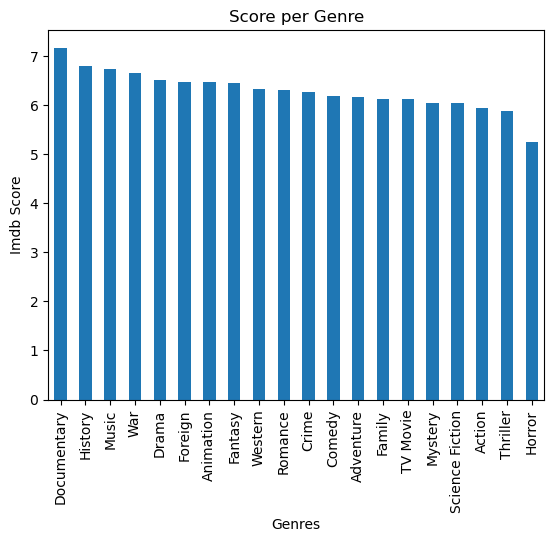

In [86]:

df_full.groupby(by = "genres").rating_imdb.mean().sort_values(ascending=False).plot(kind = "bar")
plt.xlabel("Genres")
plt.ylabel("Imdb Score")
plt.title("Score per Genre")


Text(0.5, 1.0, 'Production Companies with more movies')

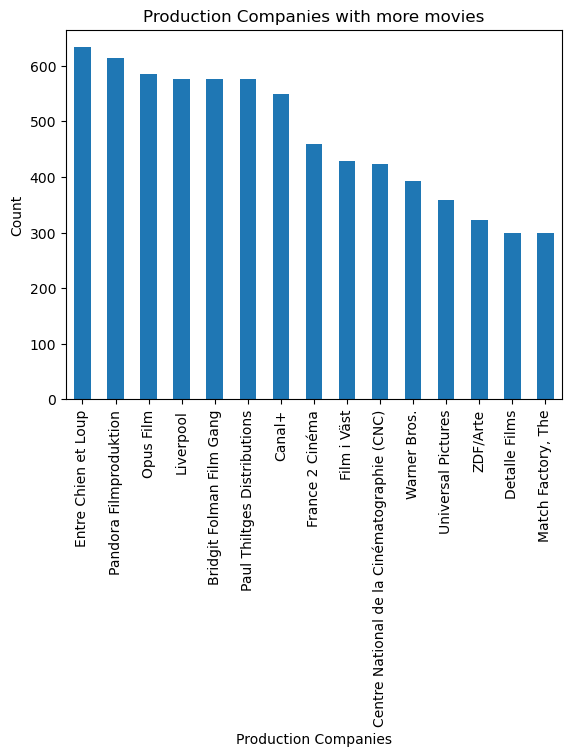

In [88]:
df_full.production_companies.value_counts()[:15].plot(kind = "bar")
plt.xlabel("Production Companies")
plt.ylabel("Count")
plt.title("Production Companies with more movies")

Text(0.5, 1.0, 'Revenue X Production Companies (Median)')

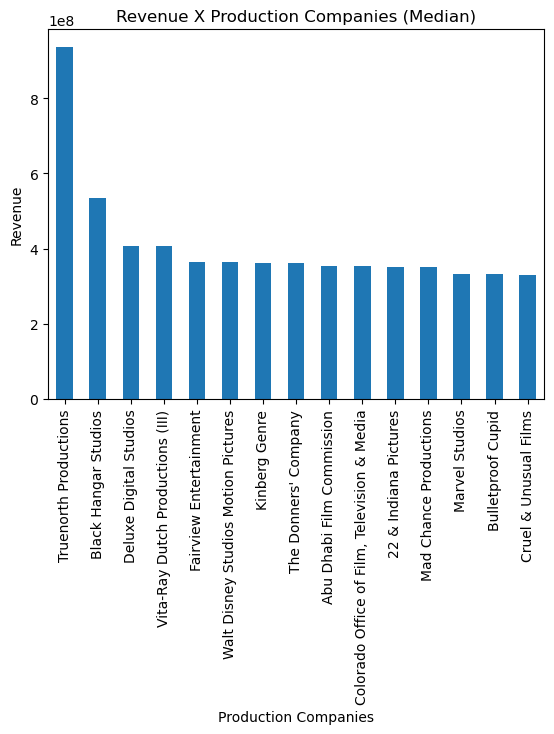

In [89]:
df_revenue.groupby(by = "production_companies").Revenue.median().sort_values(ascending=False)[:15].plot(kind = "bar")
plt.xlabel("Production Companies")
plt.ylabel("Revenue")
plt.title("Revenue X Production Companies (Median)")

Text(0.5, 1.0, 'Top Production Companies Scores (Mean)  ')

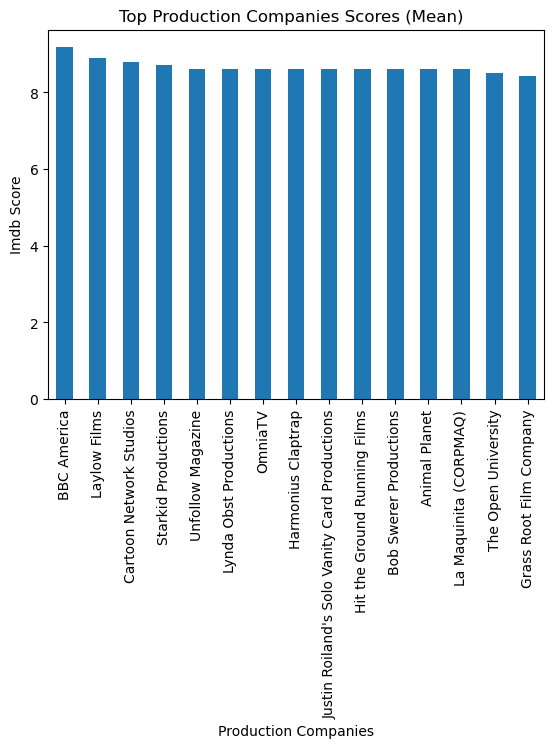

In [90]:

df_full.groupby(by = "production_companies").rating_imdb.mean().sort_values(ascending=False)[:15].plot(kind = "bar")
plt.xlabel("Production Companies")
plt.ylabel("Imdb Score")
plt.title("Top Production Companies Scores (Mean)  ")

Text(0.5, 1.0, 'USA Imdb Score (Mean)')

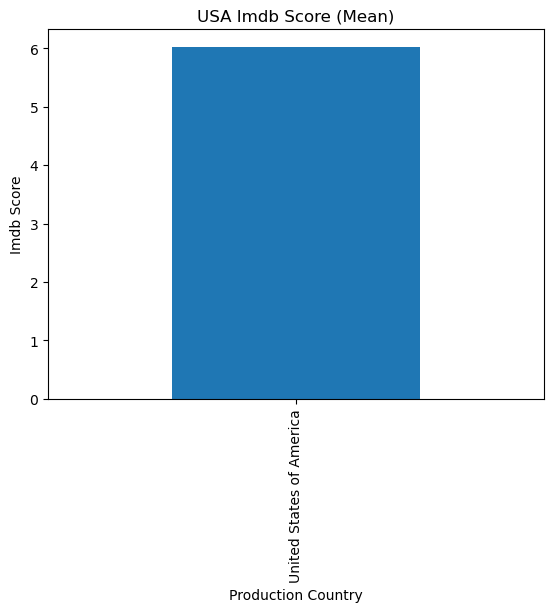

In [92]:
df_score_US = df_full[df_full.production_countries == "United States of America"]
df_score_US.groupby(by = "production_countries").rating_imdb.mean().sort_values(ascending=False).plot(kind = "bar")
plt.xlabel("Production Country")
plt.ylabel("Imdb Score")
plt.title("USA Imdb Score (Mean)")
#NAO DEVO USAR NA APRESENTACAO

C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_2732\1799739991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["class_countries"] = np.where(df_full.production_countries != "United States of America", "Others", "EUA")


Text(0.5, 1.0, 'USA x Others Imdb Score (Mean)  ')

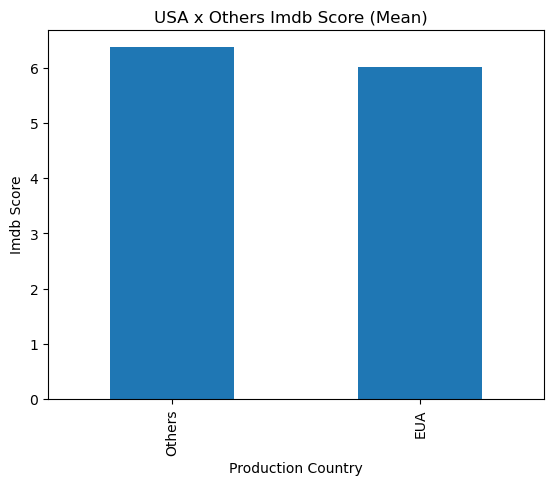

In [93]:
df_score_world = df_full[df_full.production_countries != "United States of America"]
df_score_world.rating_imdb.mean()
df_full["class_countries"] = np.where(df_full.production_countries != "United States of America", "Others", "EUA")

df_full.groupby(by = "class_countries").rating_imdb.mean().sort_values(ascending=False).plot(kind = "bar")
plt.xlabel("Production Country")
plt.ylabel("Imdb Score")
plt.title("USA x Others Imdb Score (Mean)  ")

Text(0.5, 1.0, 'Top Production Countries Scores (Mean)')

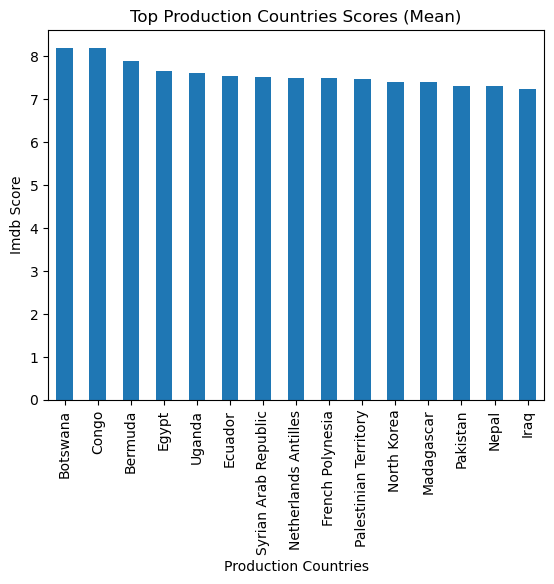

In [94]:

df_full.groupby(by = "production_countries").rating_imdb.mean().sort_values(ascending=False)[:15].plot(kind = "bar")
plt.xlabel("Production Countries")
plt.ylabel("Imdb Score")
plt.title("Top Production Countries Scores (Mean)")

Text(0.5, 1.0, 'Top Production Countries Scores (Median)')

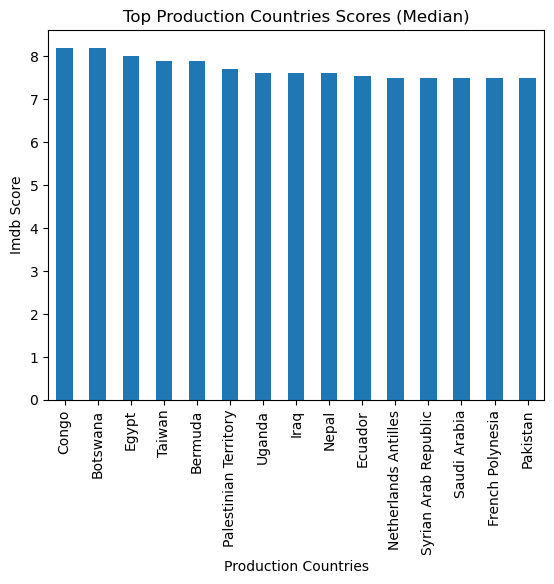

In [97]:

df_full.groupby(by = "production_countries").rating_imdb.median().sort_values(ascending=False)[:15].plot(kind = "bar")
plt.xlabel("Production Countries")
plt.ylabel("Imdb Score")
plt.title("Top Production Countries Scores (Median)")
